# Projeto Final EBAC - Cientista de Dados - Hypothyroid

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier, plot_importance

## Carregar Dados

In [2]:
df = pd.read_csv('Base_M43_Pratique_Hypothyroid.csv')
df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on thyroxine               3772 non-null   object
 3   query on thyroxine         3772 non-null   object
 4   on antithyroid medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid surgery            3772 non-null   object
 8   I131 treatment             3772 non-null   object
 9   query hypothyroid          3772 non-null   object
 10  query hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [4]:
df.describe()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
count,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,...,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772
unique,94,3,2,2,2,2,2,2,2,2,...,2,242,2,147,2,235,1,1,5,2
top,59,F,f,f,f,f,f,f,f,f,...,t,?,t,?,t,?,f,?,other,P
freq,95,2480,3308,3722,3729,3625,3719,3719,3713,3538,...,3541,231,3385,387,3387,385,3772,3772,2201,3481


A análise inicial dos dados revelou algumas questões importantes que precisam ser tratadas. Primeiramente, a maioria das colunas, incluindo variáveis que deveriam ser numéricas como idade e níveis hormonais (TSH, T3, TT4, T4U, FTI, TBG), foram erroneamente classificadas como object. Essa categorização incorreta é um forte indício da presença de valores ausentes ou caracteres não numéricos, como o ponto de interrogação ("?"), que precisam ser devidamente tratados para permitir a conversão para tipos de dados numéricos. Além disso, observou-se que diversas colunas de medição hormonal possuem uma coluna auxiliar (_measured) que indica se o exame foi realizado. Essa dualidade pode ser valiosa para decidir estratégias de imputação de valores ausentes e, potencialmente, servir como uma feature adicional para o treinamento do modelo, indicando se a medição foi ou não efetuada.

Outro ponto crítico identificado é o desequilíbrio na coluna binaryClass, que possui os valores "P" e "N". O valor "P" é predominantemente frequente, representando aproximadamente 92% dos registros (3481 de 3772). Essa disparidade significativa entre as classes pode impactar negativamente o desempenho do modelo preditivo, exigindo a aplicação de técnicas de balanceamento para garantir que o modelo não seja viesado em favor da classe majoritária.

## Pré-processamento

In [5]:
# Conversão de "?" para NaN
df.replace("?", np.nan, inplace=True)

C:\Users\arnol_73uf3lj\AppData\Local\Temp\ipykernel_17632\3499655183.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("?", np.nan, inplace=True)


In [6]:
# Conversão de Tipos Numéricos
numerical_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [7]:
# Tratar Valores Faltantes
for col in numerical_cols:
    df[col] = df.groupby('binaryClass')[col].transform(lambda x: x.fillna(x.median()))

In [8]:
# Codificação de Variáveis Categóricas
le = LabelEncoder()
df['binaryClass'] = le.fit_transform(df['binaryClass'])  # P = 1, N = 0

# One-hot para categóricas com múltiplos valores
categorical_cols = ['sex', 'referral source']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Codificar booleanos (f/t) para 0/1
bool_cols = df.columns[df.isin(['f', 't']).any()]
df[bool_cols] = df[bool_cols].replace({'f': 0, 't': 1})

C:\Users\arnol_73uf3lj\AppData\Local\Temp\ipykernel_17632\817680553.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].replace({'f': 0, 't': 1})


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3772 non-null   float64
 1   on thyroxine               3772 non-null   int64  
 2   query on thyroxine         3772 non-null   int64  
 3   on antithyroid medication  3772 non-null   int64  
 4   sick                       3772 non-null   int64  
 5   pregnant                   3772 non-null   int64  
 6   thyroid surgery            3772 non-null   int64  
 7   I131 treatment             3772 non-null   int64  
 8   query hypothyroid          3772 non-null   int64  
 9   query hyperthyroid         3772 non-null   int64  
 10  lithium                    3772 non-null   int64  
 11  goitre                     3772 non-null   int64  
 12  tumor                      3772 non-null   int64  
 13  hypopituitary              3772 non-null   int64

In [10]:
df.describe()

,age,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,...,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,binaryClass
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.0,0.0,3772.000000
mean,51.736479,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,0.062831,...,2.004650,0.938759,108.078287,0.897402,0.992700,0.897932,110.015429,0.0,NaN,0.922853
std,20.082329,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,0.242692,...,0.740408,0.239803,34.524686,0.303473,0.185308,0.302778,31.475763,0.0,NaN,0.266861
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050000,0.000000,2.000000,0.000000,0.250000,0.000000,2.000000,0.0,NaN,0.000000
25%,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.700000,1.000000,89.000000,1.000000,0.890000,1.000000,94.000000,0.0,NaN,1.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,105.000000,1.000000,0.970000,1.000000,108.000000,0.0,NaN,1.000000
75%,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.200000,1.000000,123.000000,1.000000,1.070000,1.000000,121.250000,0.0,NaN,1.000000
max,455.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,10.600000,1.000000,430.000000,1.000000,2.320000,1.000000,395.000000,0.0,NaN,1.000000


In [11]:
# Remover coluna sem informação
df.drop(columns=['TBG'], inplace=True)
df.drop(columns=['TBG measured'], inplace=True)

In [12]:
# Corrigir outliers em 'age'
df = df[df['age'] <= 100]

### Matriz de Correlação

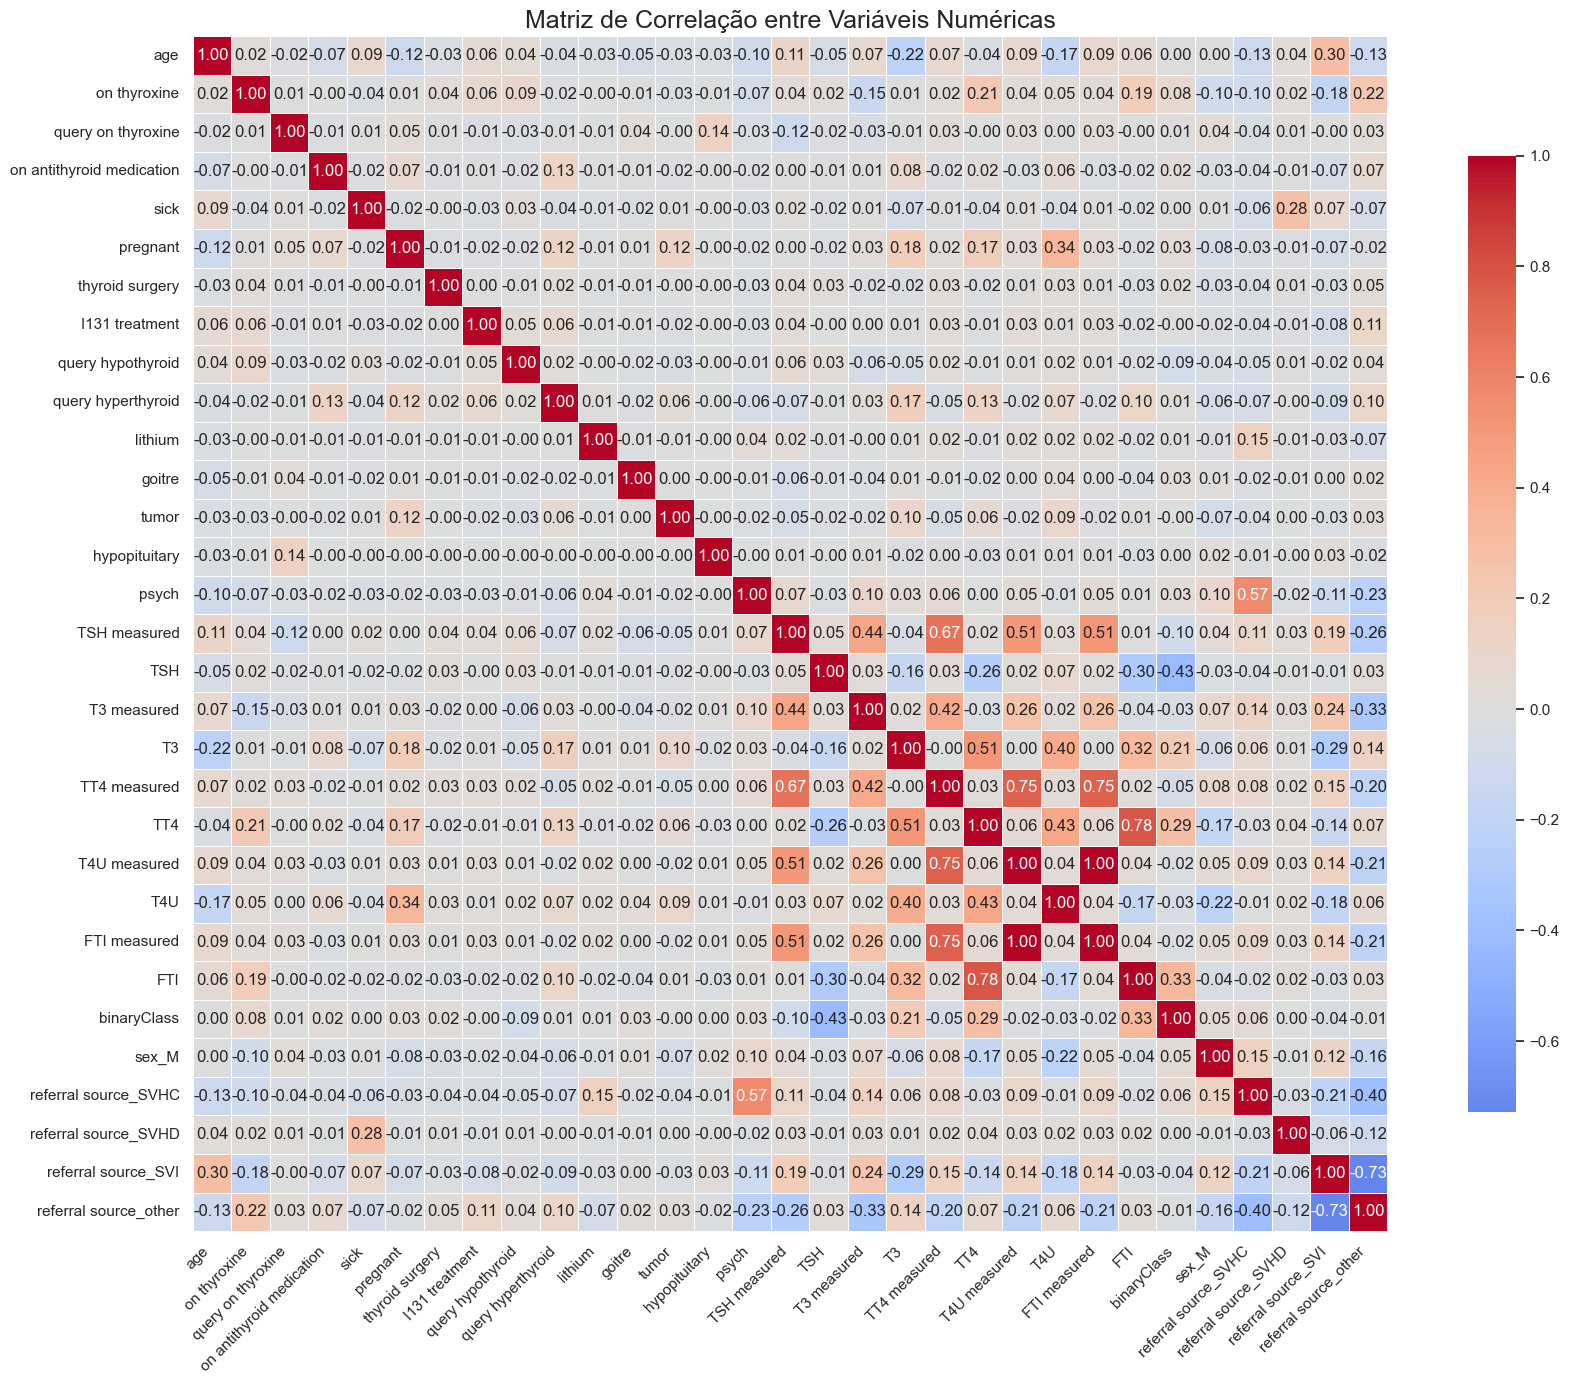

In [13]:
# Calcula a matriz de correlação
correlation_matrix = df.corr(numeric_only=True)

# Define tamanho da figura e estilo
plt.figure(figsize=(18, 14))
sns.set(style="white")

# Plot da matriz com mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.title("Matriz de Correlação entre Variáveis Numéricas", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

A matriz de correlação revela que a variável binaryClass (indicadora de disfunção na tireoide) possui correlações moderadas com TSH (0.43), FTI (-0.37), T3 (-0.33) e TT4 (-0.30), indicando que esses hormônios são relevantes para o diagnóstico e devem ser priorizados na modelagem. Algumas variáveis como psych (-0.23) e referral source_SVHD (-0.26) também apresentam associação com a variável alvo, sugerindo possíveis relações clínicas ou padrões de encaminhamento. As variáveis do tipo “measured”, como TSH measured e T3 measured, têm alta correlação com os próprios valores medidos e podem ser redundantes.

Além disso, nota-se colinearidade entre variáveis hormonais — TT4, T4U e FTI estão fortemente correlacionadas entre si (r > 0.75), o que pode causar problemas de multicolinearidade nos modelos. Recomenda-se considerar a remoção ou combinação dessas variáveis, ou ainda aplicar redução de dimensionalidade com PCA. Por fim, a origem do encaminhamento (referral source) mostra forte correlação negativa entre si por ser codificada com one-hot encoding, o que é esperado. A análise indica que variáveis hormonais são centrais para prever a disfunção, e o cuidado com redundâncias será essencial para evitar sobreajuste.

## PCA para visualização e variância explicada

In [14]:
# Normalização dos Dados para PCA
X = df.drop('binaryClass', axis=1)
y = df['binaryClass']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

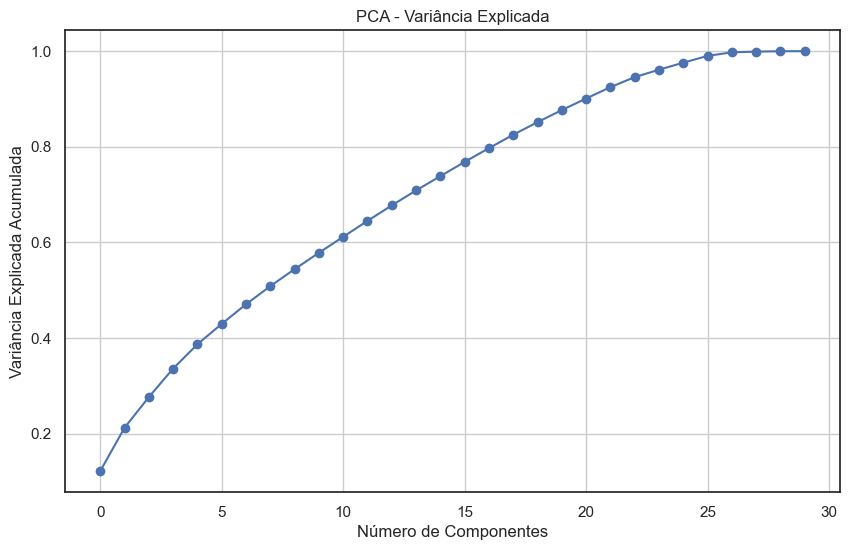

In [15]:
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA - Variância Explicada')
plt.grid(True)
plt.show()

O gráfico de variância explicada acumulada pelo PCA mostra que cerca de 20 componentes principais são suficientes para capturar aproximadamente 90% da variância dos dados. Isso indica que é possível reduzir significativamente a dimensionalidade do dataset sem grande perda de informação, o que ajuda a acelerar o treinamento, diminuir overfitting e melhorar a interpretabilidade. Essa redução é especialmente útil considerando a presença de colinearidade entre variáveis, como visto na matriz de correlação.

## Treinamento do modelo - XBOOST

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Modelo com dados ORIGINAIS para interpretar importância das features
xgb_original = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_original.fit(X_train, y_train)

In [ ]:
# Importância das features
plt.figure(figsize=(12, 6))
plot_importance(xgb_original, max_num_features=20, importance_type='gain', height=0.5)
plt.title('Importância das Features - Dados Originais')
plt.tight_layout()
plt.show()

In [ ]:
# Importância das features
plt.figure(figsize=(12, 6))
plot_importance(xgb_original, max_num_features=20, importance_type='gain', height=0.5)
plt.title('Importância das Features - Dados Originais')
plt.tight_layout()
plt.show()